In [1]:
import numpy as np 
import pandas as pd
import os

In [2]:
import mlflow

HOST = "http://localhost:5500"
EXPERIMENT_NAME = "FlightsDelay-mluser"

os.environ['MLFLOW_S3_ENDPOINT_URL']='http://minio-ml-workshop:9000'
os.environ['AWS_ACCESS_KEY_ID']='minio'
# os.environ['AWS_SECRET_ACCESS_KEY']='minio123'
os.environ['AWS_REGION']='us-east-1'
os.environ['AWS_BUCKET_NAME']='mlflow'

# Connect to local MLflow tracking server
mlflow.set_tracking_uri(HOST)

# Set the experiment name...
mlflow.set_experiment(EXPERIMENT_NAME)

mlflow.sklearn.autolog(log_input_examples=True)


In [3]:
import pyarrow.parquet as pq
import s3fs

fs = s3fs.S3FileSystem(anon=True, key='minio', secret='minio123', client_kwargs=dict(endpoint_url="http://localhost:9000"))
fs.ls("flights-data/flights-clean")
# 
df = pq.ParquetDataset('s3://flights-data/flights-clean', filesystem = fs).read_pandas().to_pandas()

In [4]:
df.isnull().sum().sort_values(ascending = False)

cancellation_reason    5245484
late_aircraft_delay    4329554
weather_delay          4329554
airline_delay          4329554
security_delay         4329554
air_system_delay       4329554
air_time                101784
arrival_delay           101784
elapsed_time            101784
wheels_on                89942
arrival_time             89942
taxi_in                  89942
wheels_off               86612
taxi_out                 86612
departure_time           83814
departure_delay          83814
tail_number              14367
DEST_LATITUDE             4610
DEST_LONGITUDE            4610
ORIG_LATITUDE             4605
ORIG_LONGITUDE            4605
scheduled_time               6
DEST_CITY                    0
DEST_AIRPORT                 0
ORIG_STATE                   0
ORIG_CITY                    0
ORIG_AIRPORT                 0
AL_AIRLINE                   0
DEST_STATE                   0
month                        0
cancelled                    0
diverted                     0
day     

In [5]:
#drop the columns for which the dataset has missing data for a large number of rows
df = df.drop(["cancellation_reason","late_aircraft_delay","weather_delay","airline_delay", "security_delay", "air_system_delay"], axis=1)

# tail number doesnot seems to effect the predictions
df = df.drop(["tail_number"], axis=1)

In [6]:
df = df.dropna(subset=["scheduled_time", "ORIG_LONGITUDE", "ORIG_LATITUDE","DEST_LONGITUDE", "DEST_LATITUDE", "departure_delay", "departure_time", "taxi_out","wheels_off", "taxi_in", "arrival_time","wheels_on", "elapsed_time", "arrival_delay","air_time"])

In [7]:
df.isnull().sum().sort_values(ascending = False)

month                  0
ORIG_STATE             0
arrival_delay          0
diverted               0
cancelled              0
AL_AIRLINE             0
ORIG_AIRPORT           0
ORIG_CITY              0
ORIG_LATITUDE          0
scheduled_arrival      0
ORIG_LONGITUDE         0
DEST_AIRPORT           0
DEST_CITY              0
DEST_STATE             0
DEST_LATITUDE          0
DEST_LONGITUDE         0
arrival_time           0
taxi_in                0
day                    0
departure_time         0
day_of_week            0
airline                0
flight_number          0
origin_airport         0
destination_airport    0
scheduled_departure    0
departure_delay        0
wheels_on              0
taxi_out               0
wheels_off             0
scheduled_time         0
elapsed_time           0
air_time               0
distance               0
DELAYED                0
dtype: int64

In [8]:
df["scheduled_departure_hour"] = df.scheduled_departure.str[:2].astype(int)
df["scheduled_departure_minute"] = df.scheduled_departure.str[2:].astype(int)

df["departure_time_hour"] = df.departure_time.str[:2].astype(int)
df["departure_time_minute"] = df.departure_time.str[2:].astype(int)

df["scheduled_arrival_hour"] = df.scheduled_arrival.str[:2].astype(int)
df["scheduled_arrival_minute"] = df.scheduled_arrival.str[2:].astype(int)

df["arrival_time_hour"] = df.arrival_time.str[:2].astype(int)
df["arrival_time_minute"] = df.arrival_time.str[2:].astype(int)

df["wheels_on_hour"] = df.wheels_on.str[:2].astype(int)
df["wheels_on_minute"] = df.wheels_on.str[2:].astype(int)

df["wheels_off_hour"] = df.wheels_off.str[:2].astype(int)
df["wheels_off_minute"] = df.wheels_off.str[2:].astype(int)


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
month,5222000.0,6.228877,3.377674,1.00000,3.00000,6.00000,9.00000,12.00000
day,5222000.0,15.694352,8.765640,1.00000,8.00000,16.00000,23.00000,31.00000
day_of_week,5222000.0,3.925464,1.990362,1.00000,2.00000,4.00000,6.00000,7.00000
flight_number,5222000.0,2169.281170,1758.518205,1.00000,728.00000,1680.00000,3230.00000,9320.00000
departure_delay,5222000.0,9.700099,37.396914,-82.00000,-5.00000,-1.00000,8.00000,1988.00000
taxi_out,5222000.0,16.100824,8.978905,1.00000,11.00000,14.00000,19.00000,225.00000
scheduled_time,5222000.0,142.087294,75.389052,18.00000,86.00000,123.00000,174.00000,718.00000
elapsed_time,5222000.0,137.277285,74.325452,14.00000,82.00000,119.00000,169.00000,766.00000
air_time,5222000.0,113.741863,72.323895,7.00000,61.00000,95.00000,144.00000,690.00000
distance,5222000.0,825.754168,608.970283,31.00000,373.00000,651.00000,1067.00000,4983.00000


In [10]:

pd.set_option('display.max_columns', None)
df.head(5)

,month,day,day_of_week,airline,flight_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,AL_AIRLINE,ORIG_AIRPORT,ORIG_CITY,ORIG_STATE,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_AIRPORT,DEST_CITY,DEST_STATE,DEST_LATITUDE,DEST_LONGITUDE,DELAYED,scheduled_departure_hour,scheduled_departure_minute,departure_time_hour,departure_time_minute,scheduled_arrival_hour,scheduled_arrival_minute,arrival_time_hour,arrival_time_minute,wheels_on_hour,wheels_on_minute,wheels_off_hour,wheels_off_minute
0,11,30,1,WN,552,LGA,DAL,0615,0609,-6.0,20.0,0629,250.0,244.0,221.0,1381,0910,3.0,0925,0913,-12.0,0,0,Southwest Airlines Co.,LaGuardia Airport (Marine Air Terminal),New York,NY,40.77724,-73.87261,Dallas Love Field,Dallas,TX,32.84711,-96.85177,0,6,15,6,9,9,25,9,13,9,10,6,29
1,11,30,1,WN,271,MCI,ATL,0615,0611,-4.0,11.0,0622,125.0,125.0,88.0,692,0850,26.0,0920,0916,-4.0,0,0,Southwest Airlines Co.,Kansas City International Airport,Kansas City,MO,39.29761,-94.71391,Hartsfield-Jackson Atlanta International Airport,Atlanta,GA,33.64044,-84.42694,0,6,15,6,11,9,20,9,16,8,50,6,22
2,11,30,1,WN,673,MCO,BNA,0615,0611,-4.0,15.0,0626,120.0,112.0,93.0,616,0659,4.0,0715,0703,-12.0,0,0,Southwest Airlines Co.,Orlando International Airport,Orlando,FL,28.42889,-81.31603,Nashville International Airport,Nashville,TN,36.12448,-86.67818,0,6,15,6,11,7,15,7,3,6,59,6,26
3,11,30,1,WN,2720,OAK,SAN,0615,0616,1.0,13.0,0629,90.0,85.0,67.0,446,0736,5.0,0745,0741,-4.0,0,0,Southwest Airlines Co.,Oakland International Airport,Oakland,CA,37.72129,-122.22072,San Diego International Airport (Lindbergh Field),San Diego,CA,32.73356,-117.18966,0,6,15,6,16,7,45,7,41,7,36,6,29
4,11,30,1,WN,805,OKC,DEN,0615,0610,-5.0,13.0,0623,105.0,95.0,73.0,495,0636,9.0,0700,0645,-15.0,0,0,Southwest Airlines Co.,Will Rogers World Airport,Oklahoma City,OK,35.39309,-97.60073,Denver International Airport,Denver,CO,39.85841,-104.66700,0,6,15,6,10,7,0,6,45,6,36,6,23


In [11]:
import category_encoders as ce

names = ['airline', "origin_airport", "destination_airport", "ORIG_CITY", "ORIG_STATE", "DEST_CITY", "DEST_STATE"]

enc = ce.ordinal.OrdinalEncoder(cols=names)
enc.fit(df)
df = enc.transform(df)


/Users/faisalmasood/.pyenv/versions/3.8.11/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):


In [12]:
df.head(5)

,month,day,day_of_week,airline,flight_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,AL_AIRLINE,ORIG_AIRPORT,ORIG_CITY,ORIG_STATE,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_AIRPORT,DEST_CITY,DEST_STATE,DEST_LATITUDE,DEST_LONGITUDE,DELAYED,scheduled_departure_hour,scheduled_departure_minute,departure_time_hour,departure_time_minute,scheduled_arrival_hour,scheduled_arrival_minute,arrival_time_hour,arrival_time_minute,wheels_on_hour,wheels_on_minute,wheels_off_hour,wheels_off_minute
0,11,30,1,1,552,1,1,0615,0609,-6.0,20.0,0629,250.0,244.0,221.0,1381,0910,3.0,0925,0913,-12.0,0,0,Southwest Airlines Co.,LaGuardia Airport (Marine Air Terminal),1,1,40.77724,-73.87261,Dallas Love Field,1,1,32.84711,-96.85177,0,6,15,6,9,9,25,9,13,9,10,6,29
1,11,30,1,1,271,2,2,0615,0611,-4.0,11.0,0622,125.0,125.0,88.0,692,0850,26.0,0920,0916,-4.0,0,0,Southwest Airlines Co.,Kansas City International Airport,2,2,39.29761,-94.71391,Hartsfield-Jackson Atlanta International Airport,2,2,33.64044,-84.42694,0,6,15,6,11,9,20,9,16,8,50,6,22
2,11,30,1,1,673,3,3,0615,0611,-4.0,15.0,0626,120.0,112.0,93.0,616,0659,4.0,0715,0703,-12.0,0,0,Southwest Airlines Co.,Orlando International Airport,3,3,28.42889,-81.31603,Nashville International Airport,3,3,36.12448,-86.67818,0,6,15,6,11,7,15,7,3,6,59,6,26
3,11,30,1,1,2720,4,4,0615,0616,1.0,13.0,0629,90.0,85.0,67.0,446,0736,5.0,0745,0741,-4.0,0,0,Southwest Airlines Co.,Oakland International Airport,4,4,37.72129,-122.22072,San Diego International Airport (Lindbergh Field),4,4,32.73356,-117.18966,0,6,15,6,16,7,45,7,41,7,36,6,29
4,11,30,1,1,805,5,5,0615,0610,-5.0,13.0,0623,105.0,95.0,73.0,495,0636,9.0,0700,0645,-15.0,0,0,Southwest Airlines Co.,Will Rogers World Airport,5,5,35.39309,-97.60073,Denver International Airport,5,5,39.85841,-104.66700,0,6,15,6,10,7,0,6,45,6,36,6,23


In [13]:
df.dtypes

month                           int32
day                             int32
day_of_week                     int32
airline                         int64
flight_number                   int32
origin_airport                  int64
destination_airport             int64
scheduled_departure            object
departure_time                 object
departure_delay               float64
taxi_out                      float64
wheels_off                     object
scheduled_time                float64
elapsed_time                  float64
air_time                      float64
distance                        int32
wheels_on                      object
taxi_in                       float64
scheduled_arrival              object
arrival_time                   object
arrival_delay                 float64
diverted                        int32
cancelled                       int32
AL_AIRLINE                     object
ORIG_AIRPORT                   object
ORIG_CITY                       int64
ORIG_STATE  

In [14]:
#drop the columns for which we have splitted the time into hours and minutes
df = df.drop(["scheduled_arrival", "arrival_time", "wheels_off", "wheels_on", "scheduled_departure", "departure_time"], axis=1)

#drop the columns which are repsented in other column too. For example origin_airport col has a key for the airport and the ORIG_AIRPORT column is a descriptive name
df = df.drop([ "AL_AIRLINE", "ORIG_AIRPORT", "DEST_AIRPORT"], axis=1)

In [15]:
from sklearn.model_selection import train_test_split 

labels = df['DELAYED']
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.2)


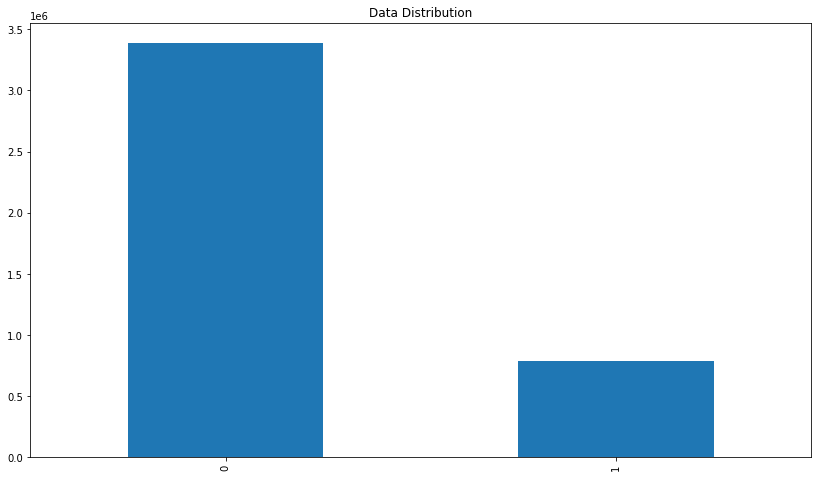

In [16]:
ax = X_train["DELAYED"].value_counts().plot(kind='bar',figsize=(14,8),title="Data Distribution")

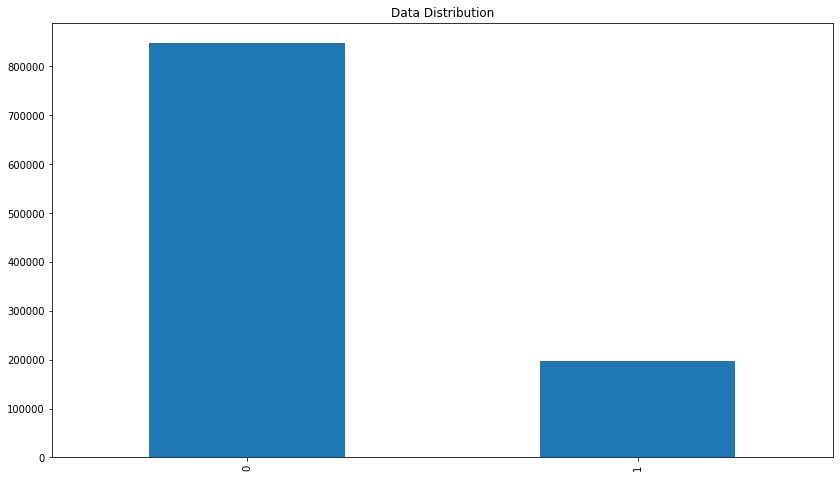

In [17]:
ax = X_test["DELAYED"].value_counts().plot(kind='bar',figsize=(14,8),title="Data Distribution")

In [18]:
X_train.pop('DELAYED')
X_test.pop('DELAYED')
print ('Training Data Shape',X_train.shape, y_train.shape)
print ('Testing Data Shape',X_test.shape, y_test.shape)

Training Data Shape (4177600, 37) (4177600,)
Testing Data Shape (1044400, 37) (1044400,)


In [19]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, eta0=0.001)
# sgd_clf.fit(X_train, y_train)

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# a more exhaustive list of hyperparams would be on the following lines:
# max_iter = [100,150,200]
# penalty = ['l2']
# loss = ['hinge','squared_hinge']
# learning_rate = ['adaptive', 'optimal']
max_iter = [10, 20]
penalty = ['l2']
loss = ['hinge']
learning_rate = ['adaptive', 'optimal']

# Merge the list into the variable
hyperparameters = dict(max_iter = max_iter , penalty = penalty, loss=loss, learning_rate=learning_rate)

model = GridSearchCV(sgd_clf, hyperparameters)
sgd_best_model = model.fit(X_train,y_train)

2022/03/20 22:47:18 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '14c8b9ea4e0c4e43a2a9d78f4d692890', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
/Users/faisalmasood/.pyenv/versions/3.8.11/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/faisalmasood/.pyenv/versions/3.8.11/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/faisalmasood/.pyenv/versions/3.8.11/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: Co

In [21]:
y_test_pred = sgd_best_model.predict(X_test)

# from sklearn.model_selection import cross_val_predict
# y_train_pred = cross_val_predict(sgd_best_model, X_test, y_test, cv=3)


In [22]:

from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(y_test, y_test_pred)
# classification_report(y_test, y_test_pred)

array([[837416,   9621],
       [   690, 196673]])

In [23]:
from sklearn.metrics import precision_score, recall_score
# precision_score(y_test, y_test_pred)
recall_score(y_test, y_test_pred) 

0.9965039039738958

## The following cells are using RandomForrestlClassifier to build the model for the given data
## Typically data scientist tries with multiple algorith to find the right fit for the given problem.
## It is upto you to execute and enhance the code and use MlFlow to comapre different alogithms.

In [24]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [25]:
# to save time for the example, we have used minimum paramaters
# this surely can be improved for a better model

n_estimators = [5, 10]
criterion = ['gini']
max_depth = [10, 15]

# Merge the list into the variable
hyperparameters = dict(n_estimators = n_estimators , criterion = criterion, max_depth=max_depth)

model = GridSearchCV(forest_clf, hyperparameters)
rf_best_model = model.fit(X_train,y_train)

2022/03/20 22:53:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a376a5a2b05b47b89af3825329368e7e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/03/20 23:17:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/faisalmasood/.pyenv/versions/3.8.11/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling I

In [26]:
y_test_pred = rf_best_model.predict(X_test)
# y_test_pred = cross_val_predict(rf_best_model, X_test, y_test, cv=3)

In [27]:
confusion_matrix(y_test, y_test_pred)

array([[847037,      0],
       [     0, 197363]])

In [28]:
precision_score(y_test, y_test_pred)

1.0

In [29]:
recall_score(y_test, y_test_pred) 

1.0